In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
folder = "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive


## Citra Menjadi Numeric (GLCM)

In [3]:
# import os
# import cv2
# from skimage.feature import graycomatrix, graycoprops

# path = f'{folder}/Larva/'
# data = []
# target = []

# for filename in os.listdir(path):
#     file_path = os.path.join(path, filename)
#     label = filename.split('--')[0]
#     img = cv2.imread(file_path)
#     rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
#     denoised = cv2.fastNlMeansDenoising(clahe, h=7, templateWindowSize=13)
#     gaussian = cv2.GaussianBlur(denoised, (0, 0), 0.1)
#     sharpened = cv2.addWeighted(denoised, 2.0, gaussian, -1.0, 0)
#     thresh = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 4)
#     mask = np.zeros(sharpened.shape, np.uint8)
#     mask[thresh == 255] = cv2.GC_PR_FGD
#     mask[thresh == 0] = cv2.GC_PR_BGD
#     bgdModel = np.zeros((1, 65), np.float64)
#     fgdModel = np.zeros((1, 65), np.float64)
#     cv2.grabCut(rgb, mask, None, bgdModel, fgdModel, 25, cv2.GC_INIT_WITH_MASK)
#     final_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
#     masked_img = sharpened * final_mask
#     coords = np.argwhere(final_mask)
#     x0, y0 = coords.min(axis=0)
#     x1, y1 = coords.max(axis=0) + 1
#     cropped = masked_img[x0:x1, y0:y1]
#     glcm = graycomatrix(cropped, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
#     features = [
#         graycoprops(glcm, 'contrast').mean(),
#         graycoprops(glcm, 'dissimilarity').mean(),
#         graycoprops(glcm, 'homogeneity').mean(),
#         graycoprops(glcm, 'energy').mean(),
#         graycoprops(glcm, 'correlation').mean(),
#         graycoprops(glcm, 'ASM').mean()
#     ]
#     data.append(features)
#     target.append(label)

In [4]:
# df = pd.DataFrame(data, columns=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'asm'])

In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# df['label'] = le.fit_transform(target)

In [6]:
# df.head(5)

In [7]:
# df.info()

In [8]:
# plt.subplots(figsize = (15,15))
# sns.heatmap(df.corr(), annot = True, vmax = 1, square = True, cmap = 'coolwarm', fmt=".2f")
# plt.show()

In [9]:
# df.to_csv(f'{folder}/Larva-GLCM.csv', index=False)

## Load Hasil GLCM

In [10]:
load_df = pd.read_csv(f'{folder}/Larva-GLCM.csv', header=0, skipinitialspace=True)

In [11]:
from sklearn.model_selection import train_test_split

x = load_df.drop('label', axis=1).values.reshape(-1, 6, 1)
y = load_df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

## CNN Tanpa Hyperparameter

In [12]:
import time
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

cnn = tf.keras.Sequential([
    tf.keras.Input(shape=(6, 1)),
    tf.keras.layers.Conv1D(16, 2, padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(32, 2, padding='same'),
    tf.keras.layers.AveragePooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

cnn.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(), metrics=['accuracy'])

start_time = time.time()
model_cnn = cnn.fit(x_train, y_train, epochs=5, verbose=0)
training_time = time.time() - start_time

train_loss, train_acc = cnn.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)

train_pred = np.argmax(cnn.predict(x_train), axis=1)
test_pred = np.argmax(cnn.predict(x_test), axis=1)

train_pre = precision_score(y_train, train_pred, average='weighted')
test_pre = precision_score(y_test, test_pred, average='weighted')

train_rec = recall_score(y_train, train_pred, average='weighted')
test_rec = recall_score(y_test, test_pred, average='weighted')

train_f1 = f1_score(y_train, train_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [13]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 16)          │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 2, 32)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,184 (63.22 KB)

 Trainable params: 5,394 (21.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,790 (42.15 KB)

In [14]:
print("CNN Tanpa Hyperparameter Tuning\n")
print("Train Accuracy\t: ", train_acc)
print("Test Accuracy\t: ", test_acc)
print("Train Loss\t: ", train_loss)
print("Test Loss\t: ", test_loss)
print("Train Precision\t: ", train_pre)
print("Test Precision\t: ", test_pre)
print("Train Recall\t: ", train_rec)
print("Test Recall\t: ", test_rec)
print("Train F1 Score\t: ", train_f1)
print("Test F1 Score\t: ", test_f1)
print("Training Time\t: ", training_time)

CNN Tanpa Hyperparameter Tuning

Train Accuracy	:  0.6321428418159485
Test Accuracy	:  0.6000000238418579
Train Loss	:  0.6582925319671631
Test Loss	:  0.6655970811843872
Train Precision	:  0.7867930029154518
Test Precision	:  0.7836065573770491
Train Recall	:  0.6321428571428571
Test Recall	:  0.6
Train F1 Score	:  0.5715888165545377
Test F1 Score	:  0.5378353376503238
Training Time	:  3.202533006668091


In [15]:
from sklearn.metrics import confusion_matrix

train_confusion_matrix = confusion_matrix(y_train, train_pred)
test_confusion_matrix = confusion_matrix(y_test, test_pred)

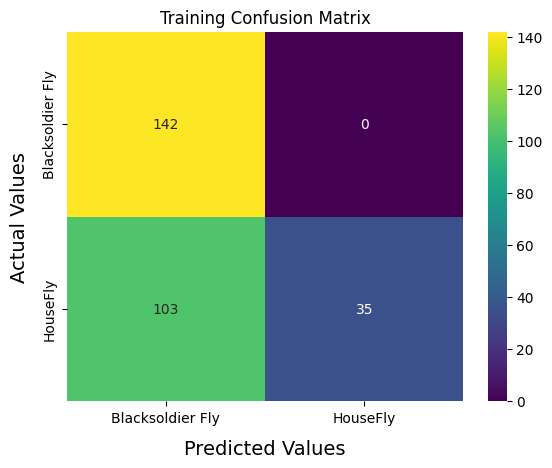

In [16]:
sns.heatmap(train_confusion_matrix, annot=True, cmap='viridis', fmt='.0f',
            xticklabels=['Blacksoldier Fly', 'HouseFly'], yticklabels=['Blacksoldier Fly', 'HouseFly'])

plt.xlabel('Predicted Values', fontdict={'size':14}, labelpad=10)
plt.ylabel('Actual Values', fontdict={'size':14}, labelpad=10)
plt.title('Training Confusion Matrix')

plt.show()

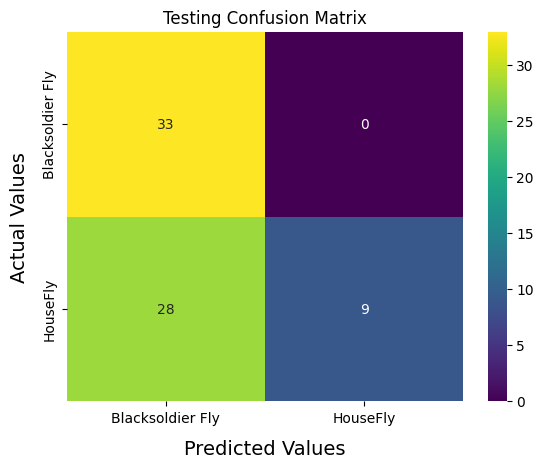

In [17]:
sns.heatmap(test_confusion_matrix, annot=True, cmap='viridis', fmt='.0f',
            xticklabels=['Blacksoldier Fly', 'HouseFly'], yticklabels=['Blacksoldier Fly', 'HouseFly'])

plt.xlabel('Predicted Values', fontdict={'size':14}, labelpad=10)
plt.ylabel('Actual Values', fontdict={'size':14}, labelpad=10)
plt.title('Testing Confusion Matrix')

plt.show()

## CNN Hyperparameter

In [18]:
from itertools import product

f1 = [16, 32]
f2 = [32, 64]
ks = [3, 5]
du = [64, 128]
bs = [8, 16]
lr = [0.01, 0.1]
ps = [1, 2]
act = ['relu', 'selu']

results = []

for f1, f2, ks, du, bs, lr, ps, act in product(f1, f2, ks, du, bs, lr, ps, act):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(6, 1)),
        tf.keras.layers.Conv1D(f1, ks, padding='same', activation=act),
        tf.keras.layers.MaxPooling1D(pool_size=ps, padding='same'),
        tf.keras.layers.Conv1D(f2, ks, padding='same', activation=act),
        tf.keras.layers.AveragePooling1D(pool_size=ps, padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(du, activation=act),
        tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.AdamW(learning_rate=lr), metrics=['accuracy'])

    st_time = time.time()
    cnn_model = model.fit(x_train, y_train, epochs=5, batch_size=bs, verbose=0)
    train_time = time.time() - st_time

    train_ls, train_ac = model.evaluate(x_train, y_train, verbose=0)
    test_ls, test_ac = model.evaluate(x_test, y_test, verbose=0)

    train_pd = np.argmax(model.predict(x_train), axis=1)
    test_pd = np.argmax(model.predict(x_test), axis=1)

    train_pr = precision_score(y_train, train_pred, average='weighted')
    test_pr = precision_score(y_test, test_pred, average='weighted')

    train_rc = recall_score(y_train, train_pred, average='weighted')
    test_rc = recall_score(y_test, test_pred, average='weighted')

    train_f = f1_score(y_train, train_pred, average='weighted')
    test_f = f1_score(y_test, test_pred, average='weighted')

    results.append({
        'params': {
            'f1': f1,
            'f2': f2,
            'kernel_size': ks,
            'dense_units': du,
            'batch_size': bs,
            'learning_rate': lr,
            'pool_size': ps,
            'activation_function': act
        },
        'train_acc': train_ac,
        'test_acc': test_ac,
        'train_loss': train_ls,
        'test_loss': test_ls,
        'train_precision': train_pr,
        'test_precision': test_pr,
        'train_recall': train_rc,
        'test_recall': test_rc,
        'train_f1': train_f,
        'test_f1': test_f,
        'training_time': train_time,
        'model': model
    })

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━

In [19]:
dfm = pd.DataFrame(results)

In [20]:
dfm.head(10)

,params,train_acc,test_acc,train_loss,test_loss,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,training_time,model
0,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.750000,0.828571,0.516198,0.475432,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.647027,"<Sequential name=sequential_1, built=True>"
1,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.500000,0.557143,0.719028,0.634194,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,6.276107,"<Sequential name=sequential_2, built=True>"
2,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.635714,0.728571,0.614924,0.591254,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,7.818900,"<Sequential name=sequential_3, built=True>"
3,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.907143,0.900000,0.355030,0.330850,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.683717,"<Sequential name=sequential_4, built=True>"
4,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.492857,0.528571,0.693717,0.692119,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.148196,"<Sequential name=sequential_5, built=True>"
5,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.528571,0.500000,0.708706,0.719050,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.757223,"<Sequential name=sequential_6, built=True>"
6,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.492857,0.528571,0.699624,0.692446,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.576090,"<Sequential name=sequential_7, built=True>"
7,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.778571,0.828571,0.573521,0.560617,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.168904,"<Sequential name=sequential_8, built=True>"
8,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.667857,0.671429,0.636307,0.667253,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.131596,"<Sequential name=sequential_9, built=True>"
9,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.660714,0.671429,0.564841,0.521294,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.736338,"<Sequential name=sequential_10, built=True>"


In [21]:
dfm.to_csv(f'{folder}/hyperparameter_tuning_results.csv', index=False)

In [22]:
sort_dfm1 = dfm.sort_values(by='test_acc', ascending=False).head(10)
sort_dfm1

,params,train_acc,test_acc,train_loss,test_loss,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,training_time,model
3,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.907143,0.900000,0.355030,0.330850,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.683717,"<Sequential name=sequential_4, built=True>"
195,"{'f1': 32, 'f2': 64, 'kernel_size': 3, 'dense_...",0.885714,0.900000,0.375403,0.366559,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.158219,"<Sequential name=sequential_196, built=True>"
99,"{'f1': 16, 'f2': 64, 'kernel_size': 5, 'dense_...",0.828571,0.885714,0.474315,0.402136,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.186946,"<Sequential name=sequential_100, built=True>"
11,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.857143,0.885714,0.378895,0.368180,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.883421,"<Sequential name=sequential_12, built=True>"
67,"{'f1': 16, 'f2': 64, 'kernel_size': 3, 'dense_...",0.864286,0.871429,0.398092,0.357900,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.925597,"<Sequential name=sequential_68, built=True>"
18,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.875000,0.871429,0.375182,0.329594,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.248419,"<Sequential name=sequential_19, built=True>"
75,"{'f1': 16, 'f2': 64, 'kernel_size': 3, 'dense_...",0.842857,0.857143,0.445240,0.387037,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,3.282433,"<Sequential name=sequential_76, built=True>"
91,"{'f1': 16, 'f2': 64, 'kernel_size': 3, 'dense_...",0.807143,0.857143,0.451356,0.372367,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.229261,"<Sequential name=sequential_92, built=True>"
130,"{'f1': 32, 'f2': 32, 'kernel_size': 3, 'dense_...",0.853571,0.857143,0.419829,0.380889,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.180799,"<Sequential name=sequential_131, built=True>"
155,"{'f1': 32, 'f2': 32, 'kernel_size': 3, 'dense_...",0.857143,0.857143,0.364814,0.343854,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.167674,"<Sequential name=sequential_156, built=True>"


In [23]:
best = dfm.loc[dfm['test_acc'].idxmax()]

best_model = best['model']
best_params = best['params']
best_train_acc = best['train_acc']
best_test_acc = best['test_acc']
best_train_loss = best['train_loss']
best_test_loss = best['test_loss']
best_train_precision = best['train_precision']
best_test_precision = best['test_precision']
best_train_recall = best['train_recall']
best_test_recall = best['test_recall']
best_train_f1 = best['train_f1']
best_test_f1 = best['test_f1']
best_training_time = best['training_time']

In [24]:
best_model.save(f'{folder}/best_cnn_model.h5')

In [25]:
best_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 6, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_4             │ (None, 2, 32)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,768 (69.41 KB)

 Trainable params: 5,922 (23.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,846 (46.28 KB)

In [26]:
print("CNN Hyperparameter Tuning\n")
print("Best Params\t\t: ", best_params)
print("Best Train Accuracy\t: ", best_train_acc)
print("Best Test Accuracy\t: ", best_test_acc)
print("Best Train Loss\t\t: ", best_train_loss)
print("Best Test Loss\t\t: ", best_test_loss)
print("Best Train Precision\t: ", best_train_precision)
print("Best Test Precision\t: ", best_test_precision)
print("Best Train Recall\t: ", best_train_recall)
print("Best Test Recall\t: ", best_test_recall)
print("Best Train F1 Score\t: ", best_train_f1)
print("Best Test F1 Score\t: ", best_test_f1)
print("Best Training Time\t: ", best_training_time)

CNN Hyperparameter Tuning

Best Params		:  {'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_units': 64, 'batch_size': 8, 'learning_rate': 0.01, 'pool_size': 2, 'activation_function': 'selu'}
Best Train Accuracy	:  0.9071428775787354
Best Test Accuracy	:  0.8999999761581421
Best Train Loss		:  0.3550303876399994
Best Test Loss		:  0.3308500349521637
Best Train Precision	:  0.7867930029154518
Best Test Precision	:  0.7836065573770491
Best Train Recall	:  0.6321428571428571
Best Test Recall	:  0.6
Best Train F1 Score	:  0.5715888165545377
Best Test F1 Score	:  0.5378353376503238
Best Training Time	:  2.6837174892425537


In [27]:
sort_dfm = dfm.sort_values(by='test_acc', ascending=False)
sort_dfm

,params,train_acc,test_acc,train_loss,test_loss,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,training_time,model
3,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.907143,0.900000,0.355030,0.330850,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.683717,"<Sequential name=sequential_4, built=True>"
195,"{'f1': 32, 'f2': 64, 'kernel_size': 3, 'dense_...",0.885714,0.900000,0.375403,0.366559,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.158219,"<Sequential name=sequential_196, built=True>"
99,"{'f1': 16, 'f2': 64, 'kernel_size': 5, 'dense_...",0.828571,0.885714,0.474315,0.402136,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.186946,"<Sequential name=sequential_100, built=True>"
11,"{'f1': 16, 'f2': 32, 'kernel_size': 3, 'dense_...",0.857143,0.885714,0.378895,0.368180,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.883421,"<Sequential name=sequential_12, built=True>"
67,"{'f1': 16, 'f2': 64, 'kernel_size': 3, 'dense_...",0.864286,0.871429,0.398092,0.357900,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.925597,"<Sequential name=sequential_68, built=True>"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,"{'f1': 32, 'f2': 64, 'kernel_size': 5, 'dense_...",0.507143,0.471429,0.711285,0.726004,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.074178,"<Sequential name=sequential_246, built=True>"
248,"{'f1': 32, 'f2': 64, 'kernel_size': 5, 'dense_...",0.510714,0.471429,0.694103,0.704450,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.129760,"<Sequential name=sequential_249, built=True>"
253,"{'f1': 32, 'f2': 64, 'kernel_size': 5, 'dense_...",0.535714,0.471429,0.851040,0.938313,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,2.127595,"<Sequential name=sequential_254, built=True>"
254,"{'f1': 32, 'f2': 64, 'kernel_size': 5, 'dense_...",0.507143,0.471429,0.695274,0.701067,0.786793,0.783607,0.632143,0.6,0.571589,0.537835,3.062892,"<Sequential name=sequential_255, built=True>"


In [28]:
best_train_pred = np.argmax(best_model.predict(x_train), axis=1)
best_test_pred = np.argmax(best_model.predict(x_test), axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [29]:
best_train_confusion_matrix = confusion_matrix(y_train, best_train_pred)
best_test_confusion_matrix = confusion_matrix(y_test, best_test_pred)

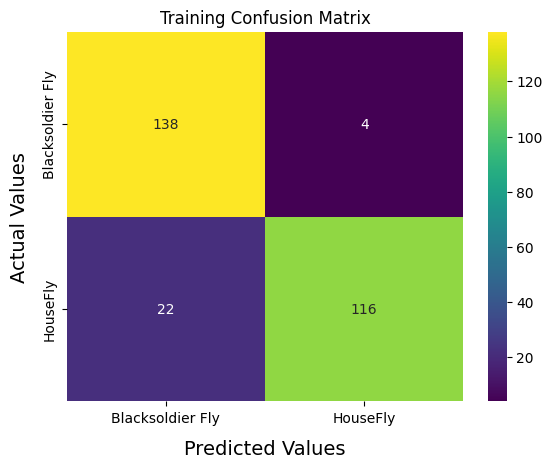

In [30]:
sns.heatmap(best_train_confusion_matrix, annot=True, cmap='viridis', fmt='.0f',
            xticklabels=['Blacksoldier Fly', 'HouseFly'], yticklabels=['Blacksoldier Fly', 'HouseFly'])

plt.xlabel('Predicted Values', fontdict={'size':14}, labelpad=10)
plt.ylabel('Actual Values', fontdict={'size':14}, labelpad=10)
plt.title('Training Confusion Matrix')

plt.show()

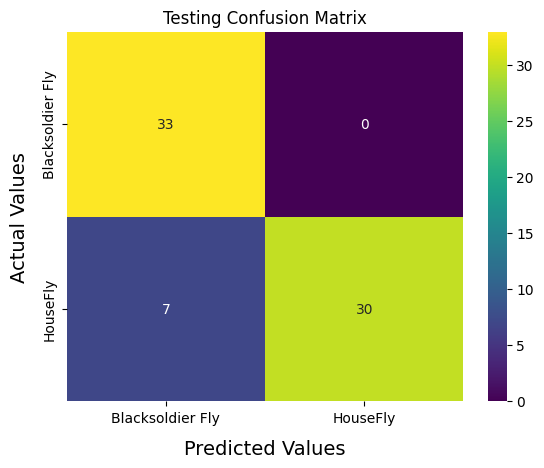

In [31]:
sns.heatmap(best_test_confusion_matrix, annot=True, cmap='viridis', fmt='.0f',
            xticklabels=['Blacksoldier Fly', 'HouseFly'], yticklabels=['Blacksoldier Fly', 'HouseFly'])

plt.xlabel('Predicted Values', fontdict={'size':14}, labelpad=10)
plt.ylabel('Actual Values', fontdict={'size':14}, labelpad=10)
plt.title('Testing Confusion Matrix')

plt.show()

## Visualisasi Komparasi Hyperparameter dan Tanpa Hyperparameter

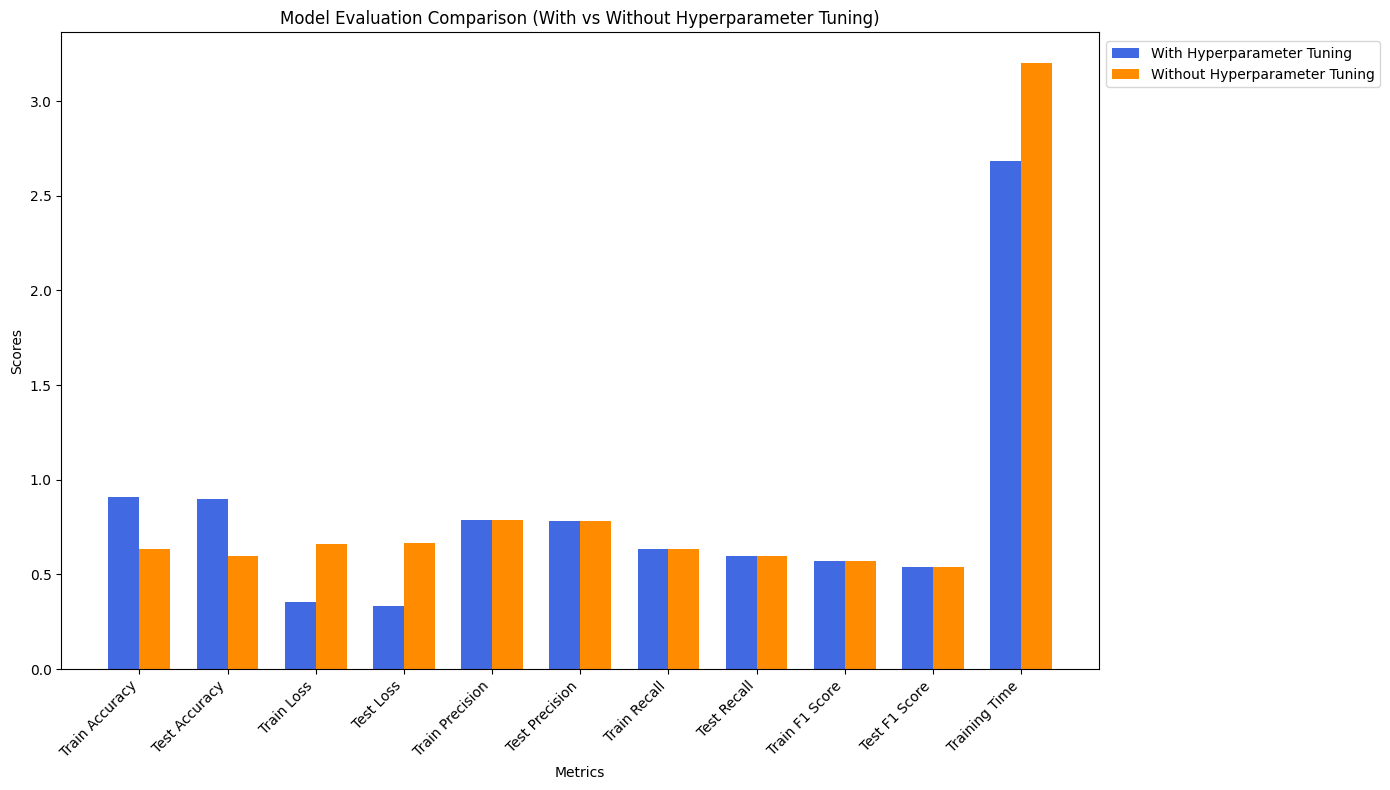

In [32]:
hyperparameter_tuning = {
    'Train Accuracy': best_train_acc,
    'Test Accuracy': best_test_acc,
    'Train Loss': best_train_loss,
    'Test Loss': best_test_loss,
    'Train Precision': best_train_precision,
    'Test Precision': best_test_precision,
    'Train Recall': best_train_recall,
    'Test Recall': best_test_recall,
    'Train F1 Score': best_train_f1,
    'Test F1 Score': best_test_f1,
    'Training Time': best_training_time
}

no_hyperparameter_tuning = {
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Train Loss': train_loss,
    'Test Loss': test_loss,
    'Train Precision': train_pre,
    'Test Precision': test_pre,
    'Train Recall': train_rec,
    'Test Recall': test_rec,
    'Train F1 Score': train_f1,
    'Test F1 Score': test_f1,
    'Training Time': training_time
}

fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.35

index = np.arange(len(hyperparameter_tuning))
for i, (metric, value) in enumerate(hyperparameter_tuning.items()):
    ax.bar(index[i], value, bar_width, color='royalblue')
    ax.bar(index[i] + bar_width, no_hyperparameter_tuning[metric], bar_width, color='darkorange')

ax.legend(['With Hyperparameter Tuning', 'Without Hyperparameter Tuning'], loc='center left', bbox_to_anchor=(1, 0.95))

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Comparison (With vs Without Hyperparameter Tuning)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(hyperparameter_tuning.keys(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

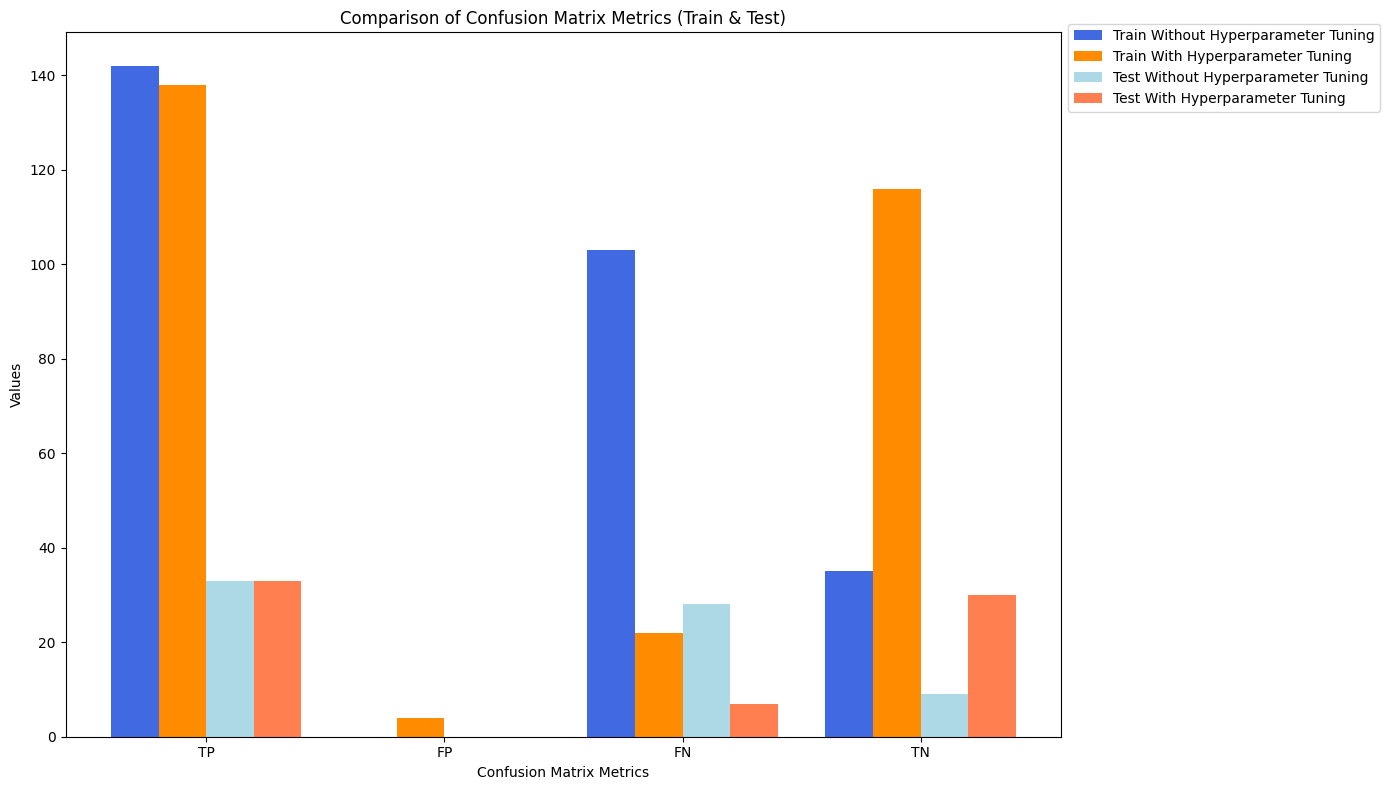

In [33]:
tp_train, fp_train, fn_train, tn_train = train_confusion_matrix.ravel()
tp_test, fp_test, fn_test, tn_test = test_confusion_matrix.ravel()

tp_best_train, fp_best_train, fn_best_train, tn_best_train = best_train_confusion_matrix.ravel()
tp_best_test, fp_best_test, fn_best_test, tn_best_test = best_test_confusion_matrix.ravel()

metrics = ['TP', 'FP', 'FN', 'TN']

train_metrics = [tp_train, fp_train, fn_train, tn_train]
test_metrics = [tp_test, fp_test, fn_test, tn_test]

best_train_metrics = [tp_best_train, fp_best_train, fn_best_train, tn_best_train]
best_test_metrics = [tp_best_test, fp_best_test, fn_best_test, tn_best_test]

fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.2
index = np.arange(len(metrics))

ax.bar(index, train_metrics, bar_width, color='royalblue', label='Train (Without Hyperparameter Tuning)')
ax.bar(index + bar_width, best_train_metrics, bar_width, color='darkorange', label='Train (With Hyperparameter Tuning)')

ax.bar(index + 2*bar_width, test_metrics, bar_width, color='lightblue', label='Test (Without Hyperparameter Tuning)')
ax.bar(index + 3*bar_width, best_test_metrics, bar_width, color='coral', label='Test (With Hyperparameter Tuning)')

ax.set_xlabel('Confusion Matrix Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Confusion Matrix Metrics (Train & Test)')
ax.set_xticks(index + 1.5*bar_width)
ax.set_xticklabels(metrics)
ax.legend(['Train Without Hyperparameter Tuning', 'Train With Hyperparameter Tuning',
           'Test Without Hyperparameter Tuning', 'Test With Hyperparameter Tuning'],
          loc='center left', bbox_to_anchor=(1, 0.95))

plt.tight_layout()
plt.show()

## Visualisasi Klasifikasi

In [34]:
# selected = np.random.choice(len(original), 6, replace=False)
# plt.figure(figsize=(15, 15))
# for i, idx in enumerate(selected):
#     ori = original[idx]
#     seg = segmentation[idx]
#     mk = (masking[idx] * 255).astype('uint8')
#     plt.subplot(6, 3, i*3 + 1)
#     plt.imshow(ori)
#     plt.title('Original')
#     plt.axis('off')
#     plt.subplot(6, 3, i*3 + 2)
#     plt.imshow(seg, cmap='gray')
#     plt.title('Segmentation')
#     plt.axis('off')
#     plt.subplot(6, 3, i*3 + 3)
#     plt.imshow(ori)
#     plt.contour(mk, colors='yellow', linewidths=1)
#     feature_input = np.array(features[idx]).reshape(1, -1, 1)
#     predicted_label = le.inverse_transform(np.argmax(best_model.predict(feature_input), axis=1))[0]
#     plt.text(10, 30, predicted_label, color='red', fontsize=12,
#              bbox=dict(facecolor='white', alpha=0.8))
#     plt.title('Result')
#     plt.axis('off')
# plt.show()